# Decision Trees Tutorial

## by 
## Michal Wojnowski
## C00213963

### Intoduction

This is a short tutorial which will teach you what decision trees are, how they work, they're strenghts and weaknesses and how to apply them to a dataset, as well as how to pre-process your data. This tutorial is aimed at fourth year coputing students so it will assume you've got prior programming knowledge and experience

### Decision Trees

Its a supervised learning algorithm used for classification. The algorithm displays splits the data according to certain parameters. As the data is broken down it forms a tree shape, hence the name.

The key requirements for the algorithm is that the attributes are categorical eg sunny, raining, thunderstorm or male, female as it will have problems with continous data

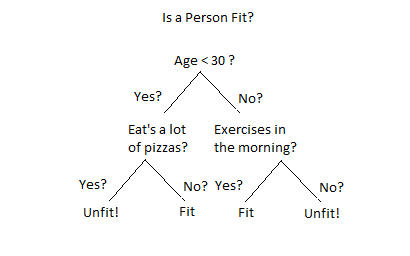

A sample decision tree to determine if the person is fit or not

### Requirements

#### Dataset

The data set that will be used for this tutorial is the Titanic dataset. This is a very popular and versitile dataset which can be used in many differente machine learning algorithms. We will be using the dataset to try and predict the likely hood of a passanger surviving based on their age, sex, class and family on board.

The dataset can be found at this link https://www.kaggle.com/c/titanic

#### Jupyter Notebook

For the tutorial we'll be using Jupyter Notebook for this tutorial. Jupyter Notebook is an open source applicaiton which you can use to create and share documents which contain live code, equations, visualization and text. This allows for a quick and easy way to share code.

### Getting started

Before we do anything we need to import the all of the different packages and libraries we'll be using in the tutorial

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import datasets, tree
from sklearn.model_selection import train_test_split

Then we import the dataset and display its contents to see what columns and how many rows we have

In [2]:
data = pd.read_csv("titanic.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Data preparation

For a decision tree to work we need to get rid of the missing data and drop unneeded columns.

However in order to know how much data we need to get rid of we need to find out how much missing data there is, so we use .isna().sum() feature for Python to tell us  

In [3]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

As we see, Cabin, while would be important to determine if someone died or not, has an overwhelming amount of missing values so we will have to drop it with other unneeded columns

In [4]:
data = data.drop(["Name", "Ticket", "Cabin"], axis=1)

We interpolate the missing age values. This fills in the missing data while spreading the ages evenly not to skew the data. After that we drop any remaining data

In [5]:
data['Age'] = data['Age'].interpolate()
data = data.dropna()

Then we take any non numberic data we have left and change it over to an intager.

In [6]:
def handle_non_numerical_data(df):
    columns = df.columns.values
    
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if data[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            data[column] = list(map(convert_to_int, df[column]))
            
    return data

data = handle_non_numerical_data(data)
print(data.head())

   PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0            1         0       3    1  22.0      1      0   7.2500         0
1            2         1       1    0  38.0      1      0  71.2833         2
2            3         1       3    0  26.0      0      0   7.9250         0
3            4         1       1    0  35.0      1      0  53.1000         0
4            5         0       3    1  35.0      0      0   8.0500         0


Once that is done we verify all data has been changed to numerical

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null int64
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
Embarked       889 non-null int64
dtypes: float64(2), int64(7)
memory usage: 69.5 KB


### Applying the algorithm

We need to split the data in two. The Y variable is what we want the X variable to try and predict

In [8]:
x = data.values
y = data['Survived'].values

Remove the Survived column from X as we dont want it to have the answer

In [9]:
x = np.delete(x,1,axis=1)

The data needs to be split into two, a training and a test dataset. The general consensus is that a 70/30 or an 80/20 split is the best, 70% being the test set. We need to split and train the dataset as the algorithm must base its prediction on trained data.

In this instance we split the x and y sets in the 70/30 split with the test_size variable being assigned the 30%

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

Here the classifier is built and the maximum depth that we want the tree to go to set 

In [11]:
titanic_classifier = tree.DecisionTreeClassifier(max_depth=5)

The classifier is then trained on the data and the algorithm makes a prediction. With the data we've passed the algorithm has about a 77% accuracy.

In [12]:
titanic_classifier.fit(x_train, y_train)
titanic_classifier.score(x_test, y_test)

0.7715355805243446

### Visualization 

Here we make a variable and list all of the columns we want used for the tree

In [13]:
FEATURE_NAMES = ['Survived', 'PClass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

The graphviz library is used to convert the algorithm and names we selected into a graph

In [14]:
tree.export_graphviz(titanic_classifier, 'tree.dot', feature_names = FEATURE_NAMES)

The generated dot file is convereted into a png format

In [15]:
! dot -Tpng tree.dot -o tree.png

Finally the imagine is selected and assigned a variable, size of the image in the notebook is set and the imagine displayed

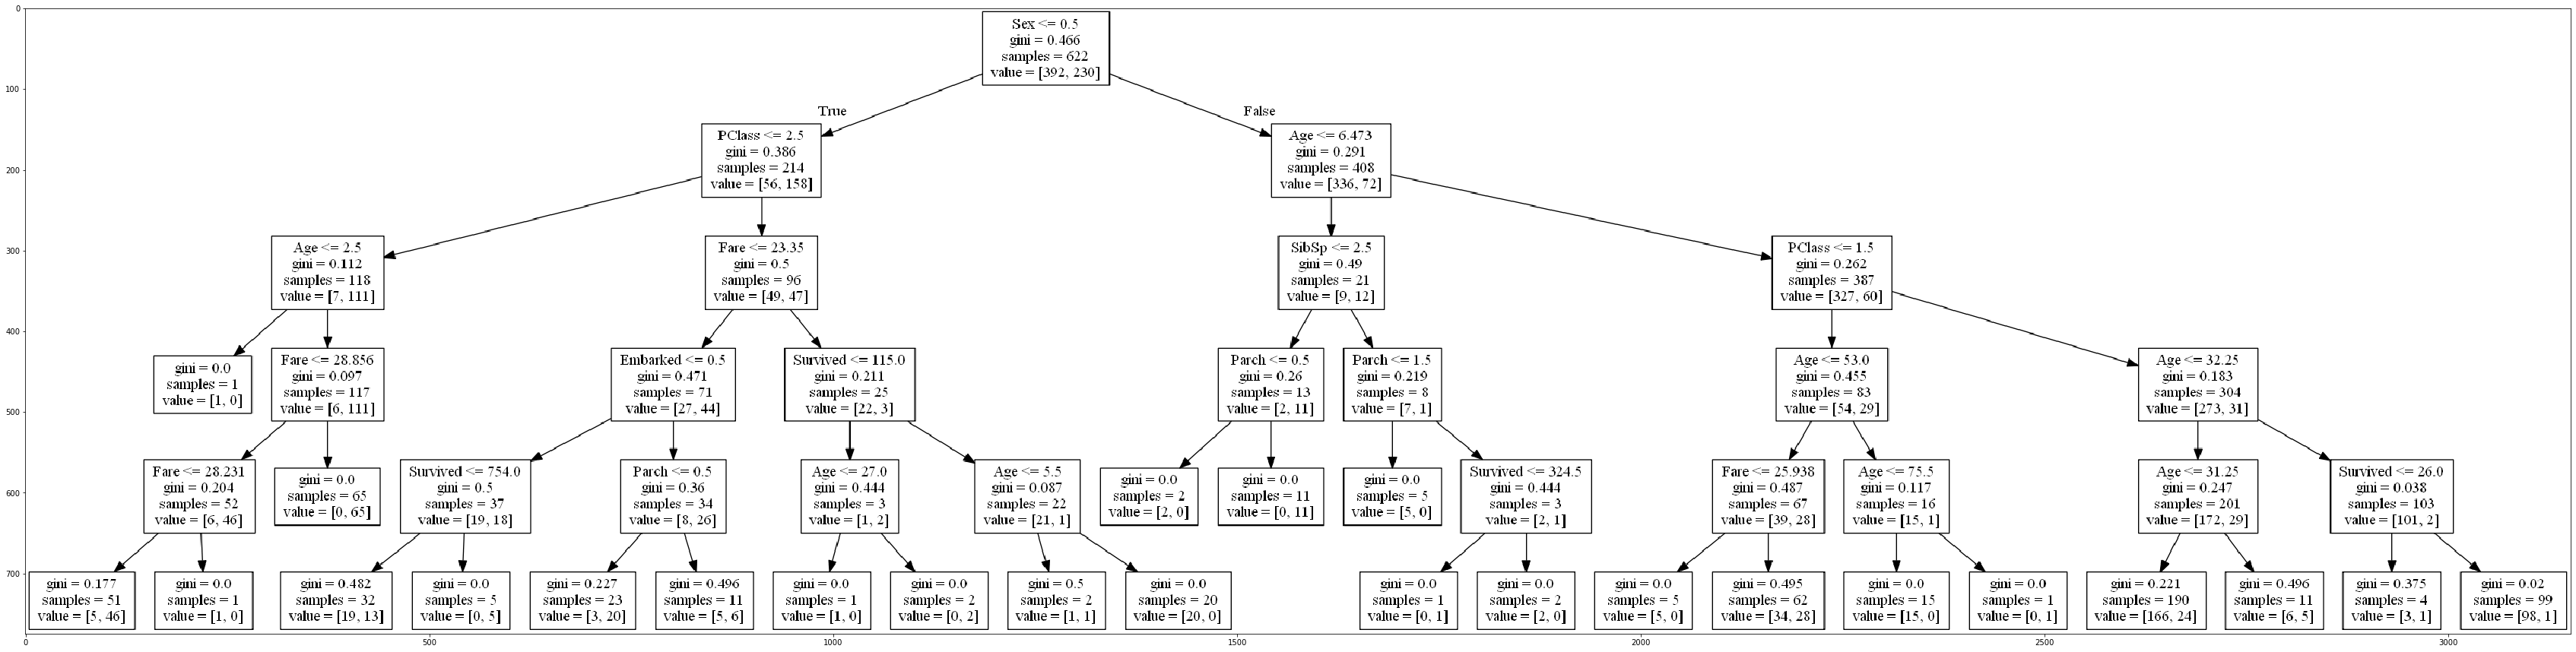

In [16]:
tree_img = cv2.imread('tree.png')
plt.figure(figsize = (60, 60))
plt.imshow(tree_img)

## Conclusion

### Strenghts

Inexpective to construct 

Fast at classifying unknown records

Classification can be performed without much computation

### Weaknesses

Does not work well for continous attributes 

Unusable on large data sets 

Missing values pose significant issues 

### Further learning

If you wish to learn more about the data preprocessing, decision tree algorithm or how to apply different algorithms to the Titanic dataset, here are a few suggestions

Data preprocessing for Machine Learning in Python https://towardsdatascience.com/data-preprocessing-for-machine-learning-in-python-2d465f83f18c

K Means with Titanic Dataset https://www.youtube.com/watch?v=j6jstahQp2A

General decision tree information https://en.wikipedia.org/wiki/Decision_tree_learning

In-depth decision tree paper https://www.sciencedirect.com/topics/computer-science/decision-tree-algorithm

### Reference

Doyle, G., 2020. Chapter 8 Data Science Decision Trees.

YouTube. 2019. Let's Build Classifiers - Decision Tree, Random Forest And Gradient Boosting. [online] Available at: <https://www.youtube.com/watch?v=uTRdOWnGOKQ> [Accessed 25 April 2020].

YouTube. 2016. Handling Non-Numeric Data - Practical Machine Learning Tutorial With Python P.35. [online] Available at: <https://www.youtube.com/watch?v=8p6XaQSIFpY> [Accessed 25 April 2020].

Towards Data Science. 2019. How To Visualize A Decision Tree In 3 Steps With Python (2020). [online] Available at: <https://towardsdatascience.com/how-to-visualize-a-decision-tree-in-5-steps-19781b28ffe2> [Accessed 26 April 2020].

S. Brid, R., 2018. [image] Available at: <https://miro.medium.com/max/820/0*LHzDR-s89Ggfqn7p.png> [Accessed 13 May 2020].